In [1]:
import os,sys
from glob import glob
import xarray as xr
from matplotlib import pyplot as plt
import numpy as np
import geopandas as gpd
import pandas as pd
import matplotlib
import fiona
import rasterio as rio

# helpers
from xarr_helpers import *

from pysptools.material_count.vd import HfcVd
import pysptools.eea as eea #endmembers extraction algorithms
import pysptools.abundance_maps as amap
import pysptools.classification as cls
from pysptools.distance import SAM, NormXCorr  
import pysptools.material_count as cnt

from earthpy.spatial import bytescale

from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib import gridspec

In [2]:
# load the table mountain shapefile
point_file = r"../arc/headwall_neon_CUSouth_poi.shp"
gdf1 = gpd.read_file(point_file)
print('point CRS: {}'.format(gdf1.crs))



point CRS: {'init': 'epsg:32613'}


In [3]:
gdf = gdf1.drop(1).reset_index()
gdf_4326 = gdf.to_crs(epsg=4326)
gdf_4326.head()

,index,Id,comments,geometry
0,0,0,dirt parking lot,POINT (-105.2320413087213 39.97927552633687)
1,2,0,tennis court (south),POINT (-105.2321048858712 39.97956622917603)
2,3,0,red hut,POINT (-105.2320315564236 39.9796903363637)
3,4,0,grass patch (south),POINT (-105.2319140238961 39.97865502556768)
4,5,0,leaf off tree,POINT (-105.2320006579609 39.97880026728588)


In [4]:
# NEON data files
data_dirs = !ls -d ../neon_data/*
neon_radiance_file = data_dirs[1] + '/L1/Spectrometer/RadianceH5/2019040920/NEON_D10_V10C_DP1_20190409_221206_radiance.h5'
neon_reflectance_file = data_dirs[1] + '/L1/Spectrometer/ReflectanceH5/2019040920/NEON_D10_V10C_DP1_20190409_221206_reflectance.h5'

# Headwall data files. Currently, only the Surface Reflectance products have been downloaded.
data_dirs_SWIR = !ls -d ../headwall_data/SWIR/*
data_dirs_VNIR = !ls -d ../headwall_data/VNIR/*

# first two directories will be from table mountain. second two are from tennis courts @ CU South
reflectance_files_VNIR_april10 = glob(data_dirs_VNIR[3] + '/*.hdr')
reflectance_files_VNIR_april10 = [f[:-4] for f in reflectance_files_VNIR_april10] # remove the .hdr

reflectance_files_SWIR_april10 = glob(data_dirs_SWIR[3] + '/*.hdr')
reflectance_files_SWIR_april10 = [f[:-4] for f in reflectance_files_SWIR_april10] # remove the .hdr

In [5]:
data_file_NEON = neon_reflectance_file

neon_id = os.path.basename(data_file_NEON).split('_')[2] # e.g., 'R10C'
print('NEON ID: ', neon_id)

NEON ID:  V10C


In [6]:
data_file_VNIR = reflectance_files_VNIR_april10[0]
data_file_SWIR = reflectance_files_SWIR_april10[0]
xarr_VNIR = xr.open_rasterio(data_file_VNIR, chunks=(256, 256, 256))
xarr_SWIR = xr.open_rasterio(data_file_SWIR, chunks=(256, 256, 256))
x_vnir, y_vnir = xarr_VNIR.coords['x'].values, xarr_VNIR.coords['y'].values
x_swir, y_swir = xarr_SWIR.coords['x'].values, xarr_SWIR.coords['y'].values

In [7]:
# then NEON (dask chunking done in-function)
x_neon, y_neon, xarr_NEON = NEON_create_refl_xarr_from_h5_file(data_file_NEON, nid=neon_id)



D:\projects\headwall_neon\notebooks\xarr_helpers.py:75: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_str = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Coordinate_System_String'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:76: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_epsg = f[nid]['Reflectance']['Metadata']['Coordinate_System']['EPSG Code'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:77: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_mapinfo = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Map_Info'].value
D:\projects\headwall_neon\notebooks\xarr_helpers.py:78: H5pyDeprecationWarning: dataset.value has been deprecated. Use dataset[()] instead.
  crs_proj4 = f[nid]['Reflectance']['Metadata']['Coordinate_System']['Proj4'].value


In [8]:
xarr_NEON.shape

(13313, 903, 426)

In [9]:
# get a headwall dataset extent
XMIN, YMIN = -100, 40
XMAX, YMAX = -110, 30

xmin, xmax = x_vnir.min(), x_vnir.max()
ymin, ymax = y_vnir.min(), y_vnir.max()
    

if xmin < XMIN:
    XMIN = xmin
if xmax > XMAX:
    XMAX = xmax
if ymin < YMIN:
    YMIN = ymin
if ymax > YMAX:
    YMAX = ymax

print(XMIN, YMIN, XMAX, YMAX)


-105.23221071371388 39.977907290428455 -105.23184026231316 39.97988019607846


In [11]:
# subset the NEON data with the full extent of headwall data cubes
from shapely.geometry import mapping, box

bbox = box(XMIN, YMIN, XMAX, YMAX)
chunk1 = gpd.GeoDataFrame({'geometry':[bbox]}, crs=fiona.crs.from_epsg(4326)).to_crs(epsg=32613)

neon_sub_cube, neon_arrs = extract_from_NEON((xarr_NEON, x_neon, y_neon), chunk1)
neon_wav, full_neon = neon_arrs

# mask the absorption bands 1340-1445, 1790-1955
i_1340 = np.where(neon_wav >= 1340)[0][0]
i_1445 = np.where(neon_wav >= 1445)[0][0]
i_1790 = np.where(neon_wav >= 1790)[0][0]
i_1995 = np.where(neon_wav >= 1995)[0][0]

# neon_sub_cube[:,:,i_1340:i_1445] = np.nan
# neon_sub_cube[:,:,i_1790:i_1995] = np.nan

# Use spatial extraction to generate the endmember spectra, and use SAM calculation to plot the spectral distance maps

# Try for Headwall

In [12]:
def np_concat_hw_arrays(hw_pair, dim='band', w_cutoff=896):
    vn, sw = hw_pair
    
    # first check the array sizes, and shave off if needed
    if vn.shape != sw.shape:
        warnings.warn('extracted shapes are not equal, shaving some off...')
        
        min_shape = (min(vn.shape[0], sw.shape[0]), min(vn.shape[1], sw.shape[1]), min(vn.shape[2], sw.shape[2]))
        sw = sw[:min_shape[0], :min_shape[1], :min_shape[2]]
        vn = vn[:min_shape[0], :min_shape[1], :min_shape[2]]
        
    # next, check the x-y offsets. If needed, shift one or the other
    x_offset = np.mean(vn.coords['x'].values - sw.coords['x'].values).ravel()[0]
    y_offset = np.mean(vn.coords['y'].values - sw.coords['y'].values).ravel()[0]
    
#     print(x_offset, y_offset)
#     if (x_offset != 0):
#         sw.assign_coords(x= sw.coords['x'].values + x_offset)
        
#     if (y_offset !=0):
#         sw.assign_coords(y = sw.coords['y'].values + y_offset)
        
    if w_cutoff > 0:
        b_cutoff = np.where(vn.coords['wavelength'] <= w_cutoff)[0][-1] + 1 # +1 due to 1 based indexing on band
        vn = vn.sel(band=slice(0, b_cutoff))
        
    print(vn.shape, sw.shape)
    new_cube = np.concatenate((vn.values,sw.values))
    coords_dict = {'x': vn.coords['x'].values,
                   'y': vn.coords['y'].values,
                   'band': np.arange(1, new_cube.shape[0]+1)}
    attrs_dict = {'wavelength': np.concatenate((vn.coords['wavelength'].values, sw.coords['wavelength'].values))}
    
    return xr.DataArray(new_cube, dims=('band', 'y', 'x'), coords=coords_dict, attrs=attrs_dict)


hw_cube = np_concat_hw_arrays((xarr_VNIR, xarr_SWIR))

C:\software\anaconda3\envs\geo_py\lib\site-packages\ipykernel_launcher.py:6: UserWarning: extracted shapes are not equal, shaving some off...
  


(223, 6086, 876) (270, 6086, 876)


In [16]:
# mask the absorption bands 1340-1445, 1790-1955
full_wav = hw_cube.attrs['wavelength']
hw_i_1340 = np.where(full_wav >= 1340)[0][0]
hw_i_1445 = np.where(full_wav >= 1445)[0][0]
hw_i_1790 = np.where(full_wav >= 1790)[0][0]
hw_i_1995 = np.where(full_wav >= 1995)[0][0]

# U_hw_arr[:,hw_i_1340:hw_i_1445] = np.nan
# U_hw_arr[:,hw_i_1790:hw_i_1995] = np.nan

# specify NIR and RED wavelengths. Find the band index for NEON and Headwall

In [48]:
red = 648.2
nir = 858.6
i_red_NEON = np.where(neon_wav >= red)[0][0]
i_nir_NEON = np.where(neon_wav >= nir)[0][0]

i_red_HW = np.where(full_wav >= red)[0][0]
i_nir_HW = np.where(full_wav >= nir)[0][0]

i_red_NEON, i_nir_NEON, i_red_HW, i_nir_HW

(54, 96, 112, 206)

In [30]:
red_NEON = neon_sub_cube[:,:,i_red_NEON]
nir_NEON = neon_sub_cube[:,:,i_nir_NEON]

red_HW = hw_cube[i_red_HW,:,:]
nir_HW = hw_cube[i_nir_HW,:,:]

In [31]:
ndvi_NEON = ((nir_NEON - red_NEON) / (nir_NEON + red_NEON)).values
ndvi_HW = ((nir_HW - red_HW) / (nir_HW + red_HW)).values

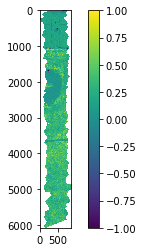

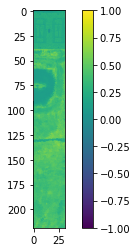

In [44]:
plt.imshow(ndvi_HW, vmin=-1, vmax=1)
plt.colorbar()
plt.show()
plt.imshow(ndvi_NEON, vmin=-1, vmax=1)
plt.colorbar()
plt.show()

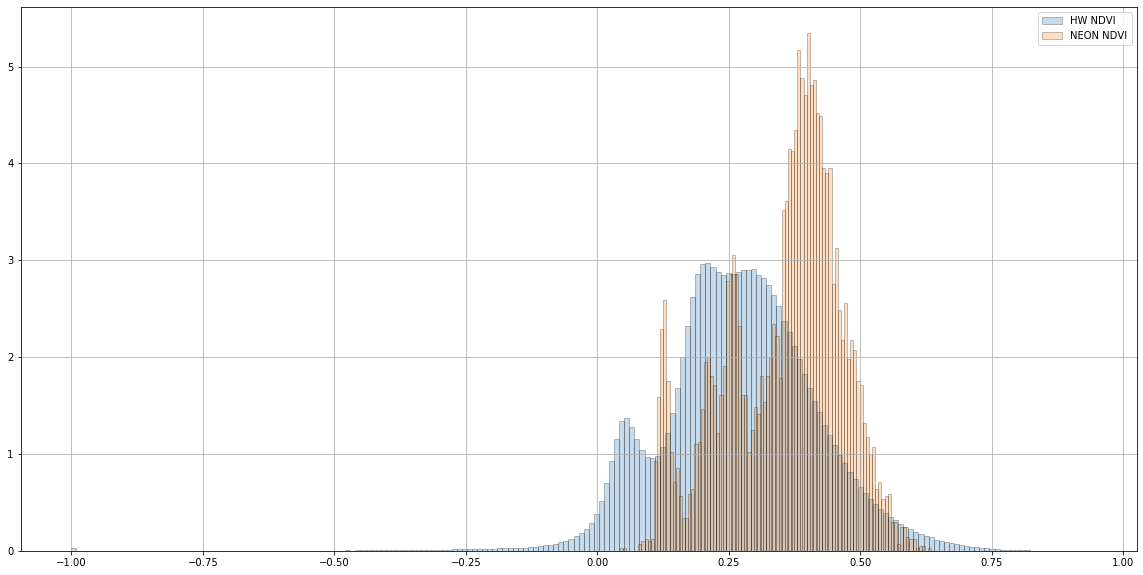

In [42]:
plt.figure(figsize=(20,10))
plt.hist(ndvi_HW[~np.isnan(ndvi_HW)], bins=200, density=True, alpha=0.25, edgecolor='k', label='HW NDVI')
plt.hist(ndvi_NEON.ravel(), bins=100, alpha=0.25, density=True, edgecolor='k', label='NEON NDVI')
plt.legend()
plt.grid(True)
plt.show()

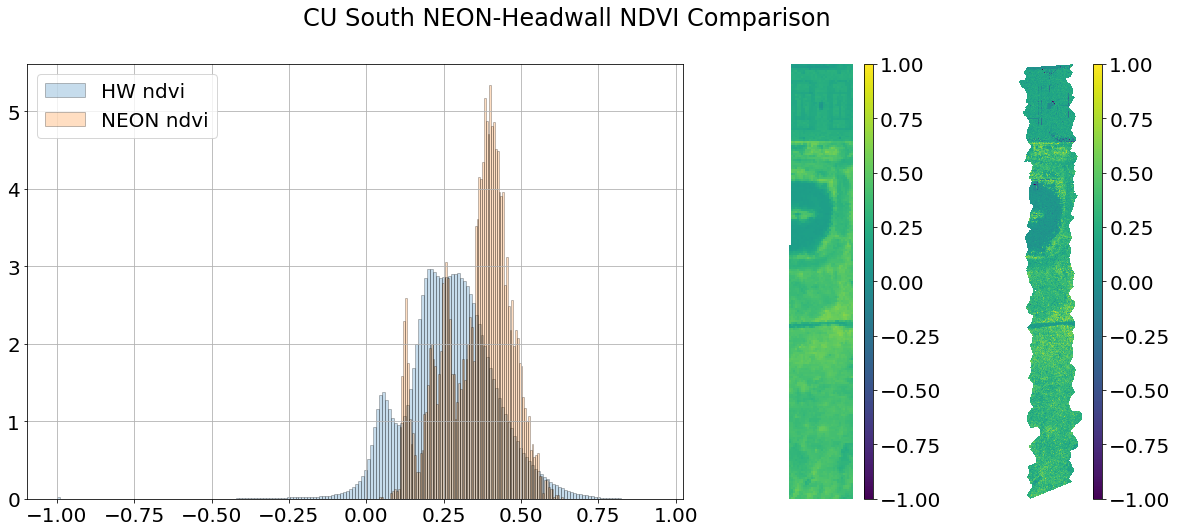

In [74]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(1, 3, width_ratios=[4, 1, 1]) 

ax0 = plt.subplot(gs[0])
p0 = ax0.hist(ndvi_HW[~np.isnan(ndvi_HW)], bins=200, density=True, alpha=0.25, edgecolor='k', label='HW ndvi')
p0 = ax0.hist(ndvi_NEON.ravel(), bins=100, alpha=0.25, density=True, edgecolor='k', label='NEON ndvi')
ax0.legend()
ax0.grid(True)

ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(ndvi_NEON, vmin=-1, vmax=1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="15%", pad=0.15)
plt.colorbar(im1, cax=cax)
ax1.axis('off')

ax2 = plt.subplot(gs[2])
im2 = ax2.imshow(ndvi_HW, vmin=-1, vmax=1)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="15%", pad=0.15)
ax2.axis('off')
plt.colorbar(im2, cax=cax)

plt.suptitle('CU South NEON-Headwall NDVI Comparison')
plt.show()

In [75]:
print(f'Headwall NDVI mean: {ndvi_HW[~np.isnan(ndvi_HW)].mean()}')
print(f'NEON NDVI mean: {ndvi_NEON[~np.isnan(ndvi_NEON)].mean()}')
print(f'Diff: {np.abs(ndvi_HW[~np.isnan(ndvi_HW)].mean() - ndvi_NEON[~np.isnan(ndvi_NEON)].mean())}')

Headwall NDVI mean: 0.2683282792568207
NEON NDVI mean: 0.3532812888704819
Diff: 0.0849530096136612


First developed and used with Landsat data for assessing leaf water content, MSI has also been useful
for applications in monitoring and detecting forest damage, and relative water content mapping (Rock
et al., 1985; Rock et al., 1986; Hunt & Rock, 1989). These strengths, combined with the possibility of
using widely available broadband multispectral data, make MSI a popular tool in climate change, land
use, invasive species, forestry, agriculture, and ecohydrological applications.
𝑀𝑆𝐼 =
𝜌1599 / 
𝜌819


In [53]:
red = 648.2
nir = 858.6
i_p1599_NEON = np.where(neon_wav >= 1599)[0][0]
i_p819_NEON = np.where(neon_wav >= 819)[0][0]

i_p1599_HW = np.where(full_wav >= 1599)[0][0]
i_p819_HW = np.where(full_wav >= 819)[0][0]

i_p1599_NEON, i_p819_NEON, i_p1599_HW, i_p819_HW

(244, 88, 341, 188)

In [54]:
p1599_NEON = neon_sub_cube[:,:,i_p1599_NEON]
p819_NEON = neon_sub_cube[:,:,i_p819_NEON]

p1599_HW = hw_cube[i_p1599_HW,:,:]
p819_HW = hw_cube[i_p819_HW,:,:]

In [56]:
msi_NEON = (p1599_NEON / p819_NEON).values
msi_HW = ( p1599_HW / p819_HW).values

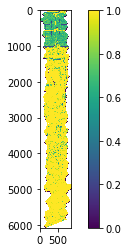

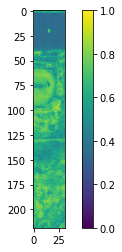

In [58]:
plt.imshow(msi_HW, vmin=0, vmax=1.)
plt.colorbar()
plt.show()
plt.imshow(msi_NEON, vmin=0, vmax=1.)
plt.colorbar()
plt.show()

First proposed by Gao (1996), the NDWI is designed as a narrowband hyperspectral index for remotely
sensing liquid water in vegetation from orbital sensors. Similar in formulation to NDVI, Gao found NDWI
to exhibit similar sensitivities to in-pixel bare soil contributions but as NDVI saturated at higher
vegetation water content values and multiple layers of leaves, NDWI continued to vary with VWC.
Jackson et al (2004) found similar results and were able to show NDWI-derived VWC compared to
ground measurements for soybeans and corn had lower bias (-0.015 and -0.010 respectively) and RMSE
(0.171 and 0.576) than NDVI-derived VWC (biases of 0.071 and 0.336, RMSE values of 0.203 and 0.735). NDWI is often considered to be a vegetation index as well as a canopy water index and has been useful
in multispectral (Landsat) vegetation water content mapping for agricultural, fire hazard assessment,
and water cycle analysis and modeling (Jackson et al., 2003).
𝑁𝐷𝑊𝐼 =
(𝜌857 − 𝜌1241) /
(𝜌857 + 𝜌1241)


In [59]:
i_p1241_NEON = np.where(neon_wav >= 1241)[0][0]
i_p857_NEON = np.where(neon_wav >= 857)[0][0]

i_p1241_HW = np.where(full_wav >= 1241)[0][0]
i_p857_HW = np.where(full_wav >= 857)[0][0]

i_p1241_NEON, i_p857_NEON, i_p1241_HW, i_p857_HW

(172, 95, 281, 205)

In [60]:
p1241_NEON = neon_sub_cube[:,:,i_p1241_NEON]
p857_NEON = neon_sub_cube[:,:,i_p857_NEON]

p1241_HW = hw_cube[i_p1241_HW,:,:]
p857_HW = hw_cube[i_p857_HW,:,:]

In [62]:
ndwi_NEON = ((p857_NEON - p1241_NEON) / (p857_NEON + p1241_NEON)).values
ndwi_HW = ((p857_HW - p1241_HW) / (p857_HW + p1241_HW)).values

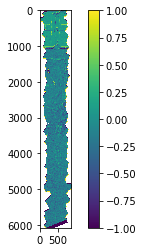

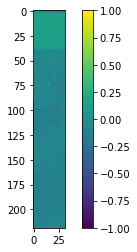

In [63]:
plt.imshow(ndwi_HW, vmin=-1, vmax=1)
plt.colorbar()
plt.show()
plt.imshow(ndwi_NEON, vmin=-1, vmax=1)
plt.colorbar()
plt.show()

C:\software\anaconda3\envs\geo_py\lib\site-packages\numpy\lib\histograms.py:829: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\software\anaconda3\envs\geo_py\lib\site-packages\numpy\lib\histograms.py:830: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


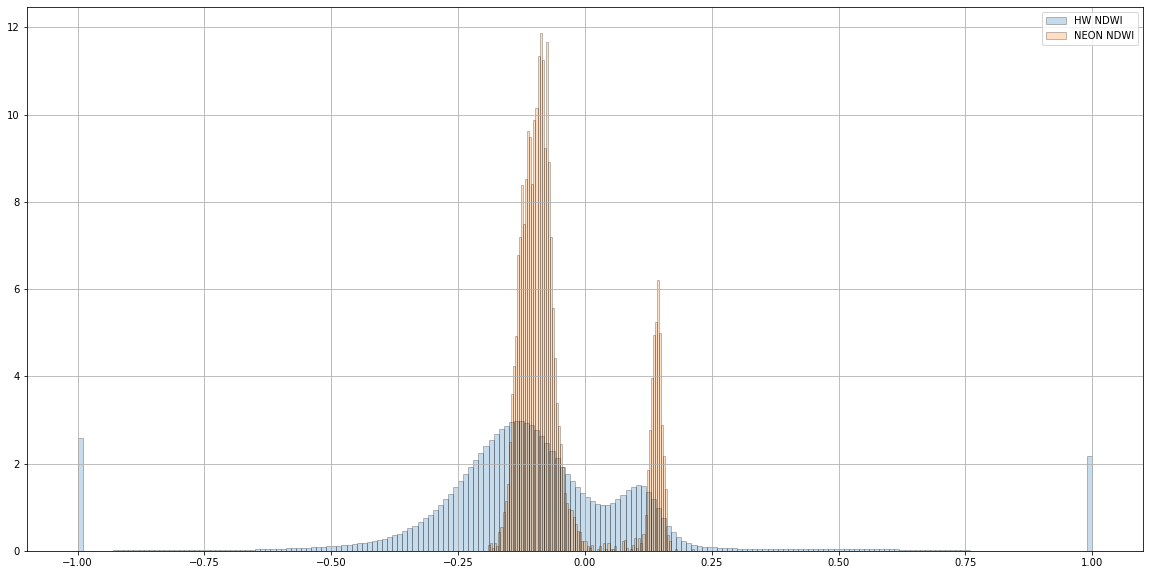

In [64]:
plt.figure(figsize=(20,10))
plt.hist(ndwi_HW[~np.isnan(ndwi_HW)], bins=200, density=True, alpha=0.25, edgecolor='k', label='HW NDWI')
plt.hist(ndwi_NEON.ravel(), bins=100, alpha=0.25, density=True, edgecolor='k', label='NEON NDWI')
plt.legend()
plt.grid(True)
plt.show()

findfont: Font family ['normal'] not found. Falling back to DejaVu Sans.


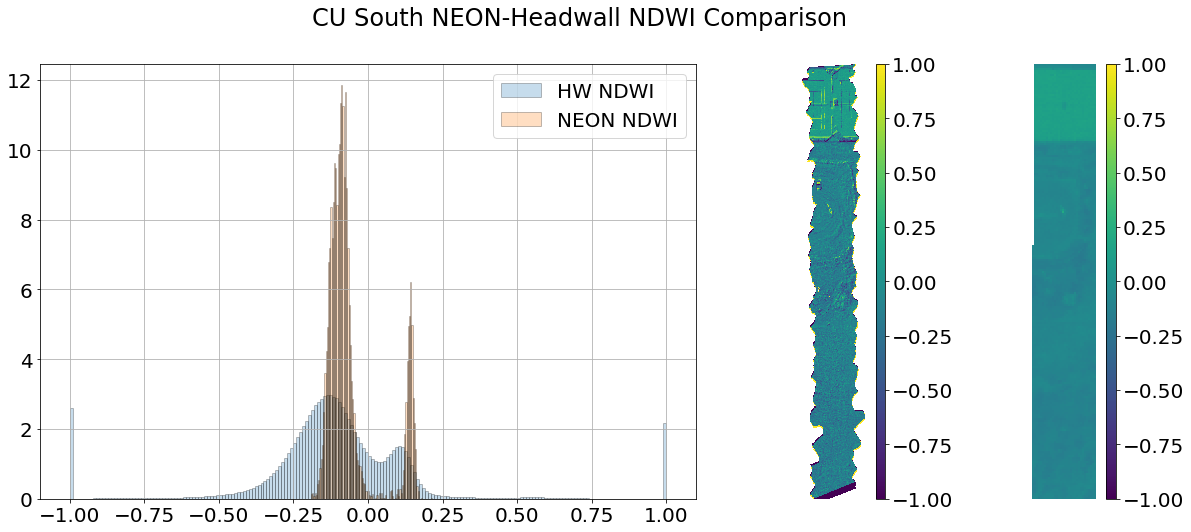

In [71]:
font = {'family' : 'normal',
        'weight' : 'medium',
        'size'   : 20}

matplotlib.rc('font', **font)

fig = plt.figure(figsize=(20,8))
gs = gridspec.GridSpec(1, 3, width_ratios=[4, 1, 1]) 

ax0 = plt.subplot(gs[0])
p0 = ax0.hist(ndwi_HW[~np.isnan(ndwi_HW)], bins=200, density=True, alpha=0.25, edgecolor='k', label='HW NDWI')
p0 = ax0.hist(ndwi_NEON.ravel(), bins=100, alpha=0.25, density=True, edgecolor='k', label='NEON NDWI')
ax0.legend()
ax0.grid(True)

ax1 = plt.subplot(gs[1])
im1 = ax1.imshow(ndwi_HW, vmin=-1, vmax=1)
divider = make_axes_locatable(ax1)
cax = divider.append_axes("right", size="15%", pad=0.15)
plt.colorbar(im1, cax=cax)
ax1.axis('off')

ax2 = plt.subplot(gs[2])
im2 = ax2.imshow(ndwi_NEON, vmin=-1, vmax=1)
divider = make_axes_locatable(ax2)
cax = divider.append_axes("right", size="15%", pad=0.15)
ax2.axis('off')
plt.colorbar(im2, cax=cax)

plt.suptitle('CU South NEON-Headwall NDWI Comparison')
plt.show()